## Importing required modules

In [ ]:
! pip install pysndfx
! apt-get install sox
! pip install sox

In [ ]:
import scipy.io.wavfile # for handling audio files
from scipy.fftpack import dct
import librosa
import numpy as np
import os
from glob import glob
import pandas as pd
import warnings
import IPython.display as ipd
from pysndfx import AudioEffectsChain
import sox
import cv2

import matplotlib.pyplot as plt  #Graphics
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.model_selection import cross_val_score


warnings.filterwarnings('ignore')
#To show graphs within the notebook
%matplotlib inline 

## Augment the data

In [ ]:
def white_noise(signal):
    wn = np.random.randn(len(signal))
    signal_wn = signal + 0.005*wn
    return signal_wn


def change_pitch(signal, sample_rate):
    signal = signal.astype('float32')
    signal = librosa.effects.pitch_shift(
        signal, sample_rate, n_steps=4, bins_per_octave=24)
    return signal.astype('int16')


def reverb(signal):
    fx = (AudioEffectsChain().reverb())
    signal_reverb = fx(signal)
    return signal_reverb


def change_speed(signal):
    speed_rate = np.random.uniform(0.85, 1.15)
    signal_speed = cv2.resize(
        signal, (1, int(len(signal) * speed_rate))).squeeze()
    return signal_speed

## Find MFCC features 

In [ ]:
def get_mfcc_features(audio_path, audio_length, dim, enhance=[0, 0, 0, 0]):

    pre_emphasis = 0.97
    frame_size = 0.01
    frame_stride = 0.01
    NFFT = 512

    sample_rate, signal = scipy.io.wavfile.read(
        audio_path)  # Read the audio file
    
    signals = [signal]
    # Add white noise
    if enhance[0] == 1:
        signals.append(white_noise(signal))
    # Change pitch
    if enhance[1] == 1:
        signals.append(change_pitch(signal, sample_rate))
    # Add reverb
    if enhance[2] == 1:
        signals.append(reverb(signal))
    # Change speed
    if enhance[3] == 1:
        signals.append(change_speed(signal))

    mfccs = []
    for signal in signals:
        signal = signal[0:int(audio_length * sample_rate)]  # audio length
        emphasized_signal = np.append(
            signal[0], signal[1:] - pre_emphasis * signal[:-1])
        frame_length, frame_step = frame_size * sample_rate, frame_stride * \
            sample_rate  # Convert from seconds to samples

        signal_length = len(emphasized_signal)
        frame_length = int(round(frame_length))  # Frame size=1ms
        frame_step = int(round(frame_step))  # stride=1ms
        # Make sure that we have at least 1 frame
        num_frames = int(np.ceil(
            float(np.abs(signal_length - frame_length)) / frame_step))

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
        pad_signal = np.append(emphasized_signal, z)

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
            np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]
        frames *= np.hamming(frame_length)
        mag_frames = np.absolute(np.fft.rfft(
            frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

        nfilt = 41
        low_freq_mel = 0
        # Convert Hz to Mel
        high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
        # Equally spaced in Mel scale
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / sample_rate)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(
            float).eps, filter_banks)  # Numerical Stability
        filter_banks = 20 * np.log10(filter_banks)  # dB

        # Finding MFCC Features
        num_ceps = dim
        mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[
            :, 1: (num_ceps + 1)]

        # mfcc -= (np.mean(mfcc, axis=0) + 1e-8)  # mean normalized

        # add 
        mfcc = np.mean(mfcc, axis=0)
        mfccs.append(mfcc)

    return mfccs

## Download the dataset

In [ ]:
! gdown https://drive.google.com/uc?id=1XkL0m34le7YJAg60yz65jBxF4ro6iYvp

Downloading...
From: https://drive.google.com/uc?id=1XkL0m34le7YJAg60yz65jBxF4ro6iYvp
To: /content/RAVDESS.zip
101MB [00:02, 40.7MB/s] 


## Unzip the dataset

In [ ]:
! unzip /content/RAVDESS.zip

Archive:  /content/RAVDESS.zip
   creating: RAVDESS/
  inflating: RAVDESS/.DS_Store       
   creating: __MACOSX/
   creating: __MACOSX/RAVDESS/
  inflating: __MACOSX/RAVDESS/._.DS_Store  
   creating: RAVDESS/0/
  inflating: RAVDESS/0/03-01-07-01-01-01-16.wav  
  inflating: RAVDESS/0/03-01-07-01-01-01-02.wav  
  inflating: RAVDESS/0/03-01-07-02-02-01-02.wav  
  inflating: RAVDESS/0/03-01-07-02-02-01-16.wav  
  inflating: RAVDESS/0/03-01-07-01-02-01-22.wav  
  inflating: RAVDESS/0/03-01-07-02-01-01-22.wav  
  inflating: RAVDESS/0/03-01-07-02-01-01-23.wav  
  inflating: RAVDESS/0/03-01-07-01-02-01-23.wav  
  inflating: RAVDESS/0/03-01-07-02-02-01-17.wav  
  inflating: RAVDESS/0/03-01-07-02-02-01-03.wav  
  inflating: RAVDESS/0/03-01-07-01-01-01-03.wav  
  inflating: RAVDESS/0/03-01-07-01-01-01-17.wav  
  inflating: RAVDESS/0/03-01-07-01-01-01-01.wav  
  inflating: RAVDESS/0/03-01-07-01-01-01-15.wav  
  inflating: RAVDESS/0/03-01-07-02-02-01-15.wav  
  inflating: RAVDESS/0/03-01-07-02-02

## Plot audio file and listen to it

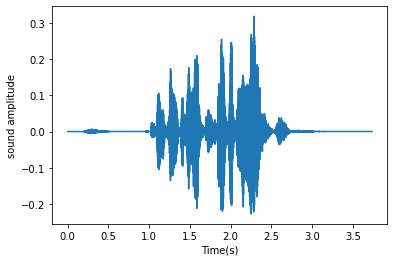

In [ ]:
fname = '/content/RAVDESS/6/03-01-06-02-01-01-18.wav'
data, sampling_rate = librosa.load(fname)

time = np.arange(0,len(data)) / sampling_rate
fig, ax = plt.subplots()
ax.plot(time, data)
ax.set(xlabel='Time(s)',ylabel='sound amplitude')

# Lets play the audio 
ipd.Audio(fname)

## Load the audio files

In [ ]:
main_path = '/content/RAVDESS'

dim = 40
audio_length = 3

audio_list_raw = []
enhance = [0] * 4
for class_ in glob(main_path + os.sep + '*'):
    for audio_path in glob(class_+ os.sep + '*.wav'):
        features = get_mfcc_features(audio_path, audio_length, dim, enhance)[0]
        audio_list_raw.append([int(class_.split(os.sep)[-1]), *features])

In [ ]:
audio_list_augmented = []

# Try permutations
enhance = [1, 1, 1, 1]
for class_ in glob(main_path + os.sep + '*'):
    for audio_path in glob(class_+ os.sep + '*.wav'):
        features_list = get_mfcc_features(audio_path, audio_length, dim, enhance)
        for features in features_list:
            audio_list_augmented.append([int(class_.split(os.sep)[-1]), *features])

## Put the features inside a dataframe

In [ ]:
cols = ['label', *[str(i+1) for i in range(len(audio_list_raw[0])-1)]]
main_df_raw = pd.DataFrame(audio_list_raw, columns=cols)

cols_augmented = ['label', *[str(i+1) for i in range(len(audio_list_augmented[0])-1)]]
main_df_augmented = pd.DataFrame(audio_list_augmented, columns=cols_augmented)

In [ ]:
df_x_raw = main_df_raw.iloc[:, 1 : ]
df_y_raw = main_df_raw.iloc[:, 0]

df_x_aug = main_df_augmented.iloc[:, 1 : ]
df_y_aug = main_df_augmented.iloc[:, 0]

## Number of examples in each class

In [ ]:
df_y_raw.head()

0    5
1    5
2    5
3    5
4    5
Name: label, dtype: int64

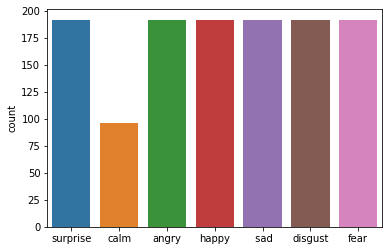

In [ ]:
# _ = sns.countplot(x=['calm', 'happy', 'sad', 'angry',' fearful', 'surprise', 'disgust'], data=df_y_raw)
ax = sns.countplot(df_y_raw.values)
_ = ax.set_xticklabels(['surprise', 'calm', 'angry', 'happy',' sad', 'disgust', 'fear'])
_ = plt.savefig("RAVDESS.png")

## Split the dataset

In [ ]:
# Raw
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(df_x_raw, df_y_raw, test_size=0.2, random_state=0)
print('Shape of train data (raw):', X_train_raw.shape)
print('Shape of train data (raw):', X_test_raw.shape)


# Augmented
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(df_x_aug, df_y_aug, test_size=0.2, random_state=0)
print('Shape of train data (augmented):', X_train_aug.shape)
print('Shape of train data (augmented):', X_test_aug.shape)

Shape of train data (raw): (998, 40)
Shape of train data (raw): (250, 40)
Shape of train data (augmented): (4992, 40)
Shape of train data (augmented): (1248, 40)


## Training random Forest

In [ ]:
# For raw
rf_raw = RandomForestClassifier(n_estimators=100)
rf_raw.fit(X_train_raw, y_train_raw)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# For augmented
rf_aug = RandomForestClassifier(n_estimators=100)
rf_aug.fit(X_train_aug, y_train_aug)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Reports for the training set

In [ ]:
pred_raw = rf_raw.predict(X_train_raw)
print('Raw data')
print("Classification Report")
print(classification_report(y_train_raw, pred_raw))
print("Confusion Report")
print(confusion_matrix(y_train_raw, pred_raw))
print('\n\nTrain accuracy:', rf_raw.score(X_train_raw, y_train_raw))

Raw data
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00       154
           3       1.00      1.00      1.00       148
           4       1.00      1.00      1.00       159
           5       1.00      1.00      1.00       160
           6       1.00      1.00      1.00       155

    accuracy                           1.00       998
   macro avg       1.00      1.00      1.00       998
weighted avg       1.00      1.00      1.00       998

Confusion Report
[[151   0   0   0   0   0   0]
 [  0  71   0   0   0   0   0]
 [  0   0 154   0   0   0   0]
 [  0   0   0 148   0   0   0]
 [  0   0   0   0 159   0   0]
 [  0   0   0   0   0 160   0]
 [  0   0   0   0   0   0 155]]


Train accuracy: 1.0


In [ ]:
pred_aug = rf_aug.predict(X_train_aug)
print('Augmented data')
print("Classification Report")
print(classification_report(y_train_aug, pred_aug))
print("Confusion Report")
print(confusion_matrix(y_train_aug, pred_aug))
print('\n\nTrain accuracy:', rf_aug.score(X_train_aug, y_train_aug))

Augmented data
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       762
           1       1.00      1.00      1.00       384
           2       1.00      1.00      1.00       780
           3       1.00      1.00      1.00       765
           4       1.00      1.00      1.00       774
           5       1.00      1.00      1.00       773
           6       1.00      1.00      1.00       754

    accuracy                           1.00      4992
   macro avg       1.00      1.00      1.00      4992
weighted avg       1.00      1.00      1.00      4992

Confusion Report
[[762   0   0   0   0   0   0]
 [  0 384   0   0   0   0   0]
 [  0   0 780   0   0   0   0]
 [  0   0   0 765   0   0   0]
 [  0   0   0   0 774   0   0]
 [  0   0   0   0   0 773   0]
 [  0   0   0   0   0   0 754]]


Train accuracy: 1.0


## Reports for the test set

In [ ]:
pred_raw = rf_raw.predict(X_test_raw)
print('Raw test data')
print("Classification Report")
print(classification_report(y_test_raw, pred_raw))
print("Confusion Report")
print(confusion_matrix(y_test_raw, pred_raw))
print('\n\nTest accuracy:', rf_raw.score(X_test_raw, y_test_raw))

Raw test data
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.49      0.48        41
           1       1.00      0.12      0.21        25
           2       0.55      0.74      0.63        38
           3       0.83      0.57      0.68        44
           4       0.45      0.73      0.56        33
           5       0.56      0.56      0.56        32
           6       0.62      0.65      0.63        37

    accuracy                           0.57       250
   macro avg       0.64      0.55      0.54       250
weighted avg       0.63      0.57      0.55       250

Confusion Report
[[20  0  8  2  5  5  1]
 [ 6  3  4  0 11  0  1]
 [ 5  0 28  0  1  2  2]
 [ 2  0  3 25  4  5  5]
 [ 3  0  2  0 24  1  3]
 [ 5  0  3  2  1 18  3]
 [ 1  0  3  1  7  1 24]]


Test accuracy: 0.568


In [ ]:
pred_aug = rf_aug.predict(X_test_aug)
print('Augmented test data')
print("Classification Report")
print(classification_report(y_test_aug, pred_aug))
print("Confusion Report")
print(confusion_matrix(y_test_aug, pred_aug))
print('\n\nTest accuracy:', rf_aug.score(X_test_aug, y_test_aug))

Augmented test data
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       198
           1       0.83      0.57      0.68        96
           2       0.69      0.79      0.74       180
           3       0.71      0.70      0.71       195
           4       0.68      0.75      0.71       186
           5       0.80      0.82      0.81       187
           6       0.86      0.71      0.78       206

    accuracy                           0.74      1248
   macro avg       0.75      0.73      0.73      1248
weighted avg       0.74      0.74      0.74      1248

Confusion Report
[[144   3  14  10   8  16   3]
 [ 12  55  10   3  14   1   1]
 [  6   3 143  15   7   3   3]
 [ 12   1  15 137  15  10   5]
 [ 18   3   8   8 140   3   6]
 [ 10   0   8   4   6 153   6]
 [ 14   1   8  15  16   6 146]]


Test accuracy: 0.7355769230769231


# Test on some samples

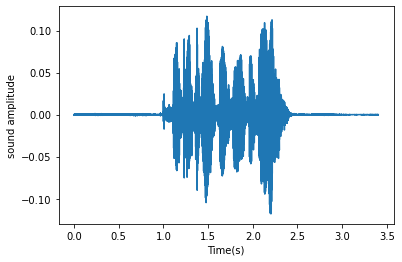

In [ ]:
fname = '/content/RAVDESS/6/03-01-06-01-01-01-10.wav'
data, sampling_rate = librosa.load(fname)

time = np.arange(0,len(data)) / sampling_rate
fig, ax = plt.subplots()
ax.plot(time, data)
ax.set(xlabel='Time(s)',ylabel='sound amplitude')

# Lets play the audio 
ipd.Audio(fname)

In [ ]:
features = get_mfcc_features(fname, audio_length, dim)[0]
pred = rf_aug.predict(np.expand_dims(features, axis=0))
mappings = ['surprise', 'calm', 'angry', 'happy',' sad', 'disgust', 'fear']
print('The class which the emotion belongs to is:', pred[0], mappings[pred[0]])

The class which the emotion belongs to is: 6 fear


# Translations for the emotions using the outputs of Bilingual Lexicon

In [ ]:
dict_ = {
  "Hindi": {
    "anger": "गुस्से",
    "disgust": "घृणा",
    "sad": "दुखी",
    "neutral": "न्यूट्रल",
    "fear": "डर",
    "surprise": "आश्चर्य",
    "calm": "शांत",
    "happy": "खुश"
  },
  "Bengali": {
    "anger": "রাগ",
    "disgust": "ঘৃণা",
    "sad": "দু:খিত",
    "neutral": "নিরপেক্ষ",
    "fear": "ভয়",
    "surprise": "অবাক",
    "calm": "শান্ত",
    "happy": "খুশি"
  }
}

In [ ]:
print('The class which the emotion belongs to is (in Hindi):', dict_['Hindi'][mappings[pred[0]]])
print('The class which the emotion belongs to is (in Bengali):', dict_['Bengali'][mappings[pred[0]]])

The class which the emotion belongs to is (in Hindi): डर
The class which the emotion belongs to is (in Bengali): ভয়
